In [1]:
# inline plotting instead of popping out
%matplotlib inline

# python 3.7.3
import os, itertools, csv

from IPython.display import Image
from IPython.display import display

# numpy  1.17.1
import numpy as np

# pandas  0.25.1
import pandas as pd

from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, roc_curve, auc
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
# matplotlib  3.1.1
import matplotlib.pyplot as plt

# load utility classes/functions that has been taught in previous labs
# e.g., plot_decision_regions()
from lib import *

# Make output directory
if not os.path.exists("output/") : os.mkdir("output/")

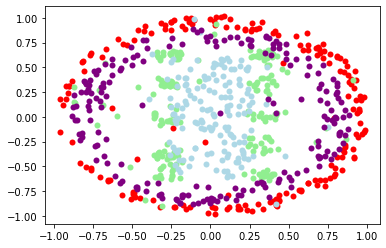

In [2]:
file = open('./train.csv', encoding='utf-8')
reader = csv.reader(file)
next(reader)
X_train = np.ndarray((0, 2))
y_train = np.ndarray((0,))
y_mapping = {'Bob': 0, 'Kate': 1, 'Mark': 2, 'Sue': 3}
i = 0
for row in reader:
  i += 1
  X_train = np.vstack((X_train, np.array(row[0:2])))
  y_train = np.append(y_train, y_mapping[row[2]])
X_train = X_train.astype(np.float)
y_train = y_train.astype(np.float)
file.close()

plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], label='Bob', c='red', linewidths=0)
plt.scatter(
    X_train[y_train == 1, 0], X_train[y_train == 1, 1], label='Kate', c='lightgreen', linewidths=0)
plt.scatter(
    X_train[y_train == 2, 0], X_train[y_train == 2, 1], label='Mark', c='lightblue', linewidths=0)
plt.scatter(X_train[y_train == 3, 0], X_train[y_train == 3, 1], label='Sue', c='purple', linewidths=0)

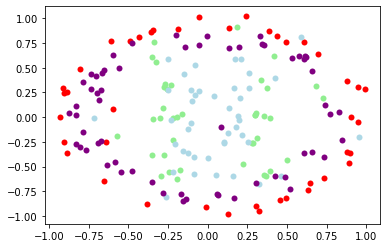

In [3]:
file = open('./test.csv', encoding='utf-8')
reader = csv.reader(file)
next(reader)
X_test = np.ndarray((0, 2))
y_test = np.ndarray((0,))
y_mapping = {'Bob': 0, 'Kate': 1, 'Mark': 2, 'Sue': 3}
i = 0
for row in reader:
  i += 1
  X_test = np.vstack((X_test, np.array(row[0:2])))
  y_test = np.append(y_test, y_mapping[row[2]])
X_test = X_test.astype(np.float)
y_test = y_test.astype(np.float)
file.close()

plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], label='Bob', c='red', linewidths=0)
plt.scatter(
    X_test[y_test == 1, 0], X_test[y_test == 1, 1], label='Kate', c='lightgreen', linewidths=0)
plt.scatter(
    X_test[y_test == 2, 0], X_test[y_test == 2, 1], label='Mark', c='lightblue', linewidths=0)
plt.scatter(X_test[y_test == 3, 0], X_test[y_test == 3, 1], label='Sue', c='purple', linewidths=0)

### Using gridsearch to find best hyperparameter of SVC

In [4]:
print('[Grid Search for SVC\'s hyperparameter]')
param_C = [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
param_gamma = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]

svm = SVC(random_state=0)

param_grid = [{'C': param_C, 
               'gamma': param_gamma, 
               'kernel': ['rbf']}]
gs = GridSearchCV(estimator=svm, 
                  param_grid=param_grid, 
                  scoring='accuracy')
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

[Grid Search for SVC's hyperparameter]
0.8631457988600845
{'C': 1000.0, 'gamma': 1.0, 'kernel': 'rbf'}


### SVC, Decision Tree, KNN, Logistic Regression

In [5]:
print('[SVM, DecisionTree, KNN, Logistic Regression CV]')
clf_labels = ['SVC', 'DecisionTree', 'KNN', 'LogisticRegression']

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', SVC(kernel='rbf', random_state=0, gamma=1.0, C=1000.0, probability=True)]])
pipe2 = Pipeline([['clf', DecisionTreeClassifier(max_depth = 10, random_state = 0)]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier(n_neighbors = 5)]])
pipe4 = Pipeline([['sc', StandardScaler()],['clf', LogisticRegression(solver='lbfgs', max_iter = 2000)]])

for pipe, label in zip([pipe1, pipe2, pipe3, pipe4], clf_labels):
    scores = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=10, scoring='accuracy')
    print('%s: %.3f (+/- %.3f)' % (label, scores.mean(), scores.std()))

[SVM, DecisionTree, KNN, Logistic Regression CV]
SVC: 0.862 (+/- 0.059)
DecisionTree: 0.772 (+/- 0.071)
KNN: 0.821 (+/- 0.053)
LogisticRegression: 0.278 (+/- 0.038)


In [6]:
print('[SVC Testing]')
pipe1.fit(X_train,y_train)
y_pred = pipe1.predict(X_test)
print('\nTesting Accuracy: %.3f' % accuracy_score(y_test, y_pred))

[SVC Testing]

Testing Accuracy: 0.832


### Polynomial LogisticRegression

In [7]:
print('[Grid Search For The Best Poly Degree For LogisticRegression]')
degrees = [1,2,3,4,5,6,7,8,9,10]

for degree in degrees:
    poly = PolynomialFeatures(degree = degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    scores = cross_val_score(estimator=pipe4, X=X_train_poly, y=y_train, cv=10, scoring='accuracy')
    print('Degree %d: %.3f (+/- %.3f)' % (degree, scores.mean(), scores.std()))

[Grid Search For The Best Poly Degree For LogisticRegression]
Degree 1: 0.278 (+/- 0.038)
Degree 2: 0.836 (+/- 0.035)
Degree 3: 0.828 (+/- 0.052)
Degree 4: 0.844 (+/- 0.047)
Degree 5: 0.836 (+/- 0.048)
Degree 6: 0.846 (+/- 0.053)
Degree 7: 0.839 (+/- 0.051)
Degree 8: 0.850 (+/- 0.055)
Degree 9: 0.851 (+/- 0.058)
Degree 10: 0.855 (+/- 0.059)


In [8]:
print('[LogisticRegression degree = 10 Testing ]')
pipe4 = Pipeline([['sc', StandardScaler()],['poly', PolynomialFeatures(degree = 10)],
                  ['clf', LogisticRegression(solver='lbfgs', max_iter = 4000)]])
pipe4.fit(X_train,y_train)
y_pred = pipe4.predict(X_test)
print('\nTesting Accuracy: %.3f' % accuracy_score(y_test, y_pred))

[LogisticRegression degree = 10 Testing ]

Testing Accuracy: 0.832


### Soft Voting of SVC, Decision Tree, KNN, LogisticRegression

In [9]:
print('[Voting CV]')
poly_grid = [2,3,4]
best_poly = 0
best_vt, best_w, best_score = None, (), -1
for poly in poly_grid:
    for a, b, c, d in list(itertools.permutations(range(0,4))):
        pipe4 = Pipeline([['sc', StandardScaler()],['poly', PolynomialFeatures(degree = poly)],
                      ['clf', LogisticRegression(solver='lbfgs', max_iter = 500)]])
        clf = VotingClassifier(estimators=[('svc', pipe1), ('dt', pipe2), ('knn', pipe3), ('lr',pipe4)], 
                               voting='soft', weights=[a,b,c,d])
        scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='accuracy')
        if best_score < scores.mean():
            best_vt, best_w, best_score = clf, (a, b, c, d), scores.mean()
            best_poly = poly

print('\nWith logistic regression degree = %d Best %s: %.3f' % (best_poly,best_w, best_score))


[Voting CV]

With logistic regression degree = 2 Best (3, 0, 1, 2): 0.881


In [10]:
print('[Voting Testing]')

best_vt.fit(X_train,y_train)

y_pred = best_vt.predict(X_test)

print('\nTesting Accuracy: %.3f' % accuracy_score(y_test, y_pred))

[Voting Testing]

Testing Accuracy: 0.838


### Hard Voting of SVC, Decision Tree, KNN, LogisticRegression

In [11]:
print('[Voting CV]')
pipe4 = Pipeline([['sc', StandardScaler()],['poly', PolynomialFeatures(degree = best_poly)],
                      ['clf', LogisticRegression(solver='lbfgs', max_iter = 200)]])
clf = VotingClassifier(estimators=[('svc', pipe1), ('dt', pipe2), ('knn', pipe3), ('lr',pipe4)], 
                           voting='hard')
scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='accuracy')
print('%.3f (+/- %.3f)' % (scores.mean(), scores.std()))

[Voting CV]
0.858 (+/- 0.060)


In [12]:
print('[Voting Testing]')

clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

print('\nTesting Accuracy: %.3f' % accuracy_score(y_test, y_pred))

[Voting Testing]

Testing Accuracy: 0.816


### Bagging using Decision Tree

In [13]:
print('[Bagging of tree CV]')
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=0)
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, 
                        max_samples=0.7, bootstrap=True,
                        max_features=1.0, bootstrap_features=False, 
                        n_jobs=1, random_state=1)

scores = cross_val_score(estimator=bag, X=X_train, y=y_train, cv=10, scoring='accuracy')
print('%.3f (+/- %.3f)' % (scores.mean(), scores.std()))

[Bagging of tree CV]
0.825 (+/- 0.041)


In [14]:
print('[Bagging of tree Testing]')
bag = bag.fit(X_train, y_train)
y_pred = bag.predict(X_test)

print('Testing Accuracy: %.3f' % accuracy_score(y_test, y_pred) )

[Bagging of tree Testing]
Testing Accuracy: 0.811


### Bagging using Perceptron

In [15]:
print('[Bagging of Perceptron CV]')
perceptron = Perceptron()
bag = BaggingClassifier(base_estimator=perceptron, n_estimators=500, 
                        max_samples=0.7, bootstrap=True,
                        max_features=1.0, bootstrap_features=False, 
                        n_jobs=1, random_state=1)

scores = cross_val_score(estimator=bag, X=X_train, y=y_train, cv=10, scoring='accuracy')
print('%.3f (+/- %.3f)' % (scores.mean(), scores.std()))

[Bagging of Perceptron CV]
0.291 (+/- 0.053)


In [16]:
print('[Bagging of Perceptron Testing]')
bag = bag.fit(X_train, y_train)
y_pred = bag.predict(X_test)

print('Testing Accuracy: %.3f' % accuracy_score(y_test, y_pred) )

[Bagging of Perceptron Testing]
Testing Accuracy: 0.243


### AdaBoost using Decision Tree with tree depth search and Cross Validation

In [17]:
print('[AdaBoost of tree CV]')

best_depth, best_score = -1, -1
depth_grid = []
depth_grid.extend(range(1,20))

for depth in depth_grid:
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=0)
    ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500)
    scores = cross_val_score(ada, X_train, y_train, cv=5)
    print('[Tree depth = %d]\nValidation accuracy: %.3f' % (depth, scores.mean()))
    if scores.mean() > best_score:
        best_depth, best_score = depth, scores.mean()


[AdaBoost of tree CV]
[Tree depth = 1]
Validation accuracy: 0.611
[Tree depth = 2]
Validation accuracy: 0.721
[Tree depth = 3]
Validation accuracy: 0.744
[Tree depth = 4]
Validation accuracy: 0.779
[Tree depth = 5]
Validation accuracy: 0.816
[Tree depth = 6]
Validation accuracy: 0.825
[Tree depth = 7]
Validation accuracy: 0.824
[Tree depth = 8]
Validation accuracy: 0.827
[Tree depth = 9]
Validation accuracy: 0.822
[Tree depth = 10]
Validation accuracy: 0.828
[Tree depth = 11]
Validation accuracy: 0.809
[Tree depth = 12]
Validation accuracy: 0.774
[Tree depth = 13]
Validation accuracy: 0.771
[Tree depth = 14]
Validation accuracy: 0.798
[Tree depth = 15]
Validation accuracy: 0.762
[Tree depth = 16]
Validation accuracy: 0.770
[Tree depth = 17]
Validation accuracy: 0.770
[Tree depth = 18]
Validation accuracy: 0.759
[Tree depth = 19]
Validation accuracy: 0.770


In [18]:
print('[AdaBoost of tree, tree depth = %d]' % best_depth)
tree = DecisionTreeClassifier(criterion='entropy', max_depth=best_depth, random_state=0)
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500)
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)
print('Testing accuracy %.3f' % accuracy_score(y_test, y_pred))

[AdaBoost of tree, tree depth = 10]
Testing accuracy 0.816


### Soft Voting of AdaBoost of tree and KNN

In [19]:
best_vt, best_score = None, -1
for a, b in list(itertools.permutations(range(0,2))):
    clf = VotingClassifier(estimators=[('Ada', ada),('knn', pipe3)], 
                           voting='soft', weights=[a,b])
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='accuracy')
    print('%s: %.3f (+/- %.3f)' % ((a,b), scores.mean(), scores.std()))
    if best_score < scores.mean():
        best_vt = clf


(0, 1): 0.821 (+/- 0.053)
(1, 0): 0.828 (+/- 0.041)


In [20]:
print('[Voting Testing]')

best_vt.fit(X_train,y_train)

y_pred = best_vt.predict(X_test)

print('\nTesting Accuracy: %.3f' % accuracy_score(y_test, y_pred))

[Voting Testing]

Testing Accuracy: 0.805


### Hard Voting of AdaBoost of tree and KNN

In [21]:
clf = VotingClassifier(estimators=[('Ada', ada),('knn', pipe3)], 
                           voting='hard')
scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='accuracy')
print('%.3f (+/- %.3f)' % (scores.mean(), scores.std()))

0.814 (+/- 0.058)


In [22]:
print('[Voting Testing]')

clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

print('\nTesting Accuracy: %.3f' % accuracy_score(y_test, y_pred))

[Voting Testing]

Testing Accuracy: 0.773


### Soft Voting of Bagging of tree and KNN

In [27]:
best_vt, best_score = None, -1
tree = DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=0)
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, 
                        max_samples=0.7, bootstrap=True,
                        max_features=1.0, bootstrap_features=False, 
                        n_jobs=1, random_state=1)
for a, b in list(itertools.permutations(range(0,2))):
    clf = VotingClassifier(estimators=[('bag', bag),('knn', pipe3)], 
                           voting='soft', weights=[a,b])
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='accuracy')
    print('%s: %.3f (+/- %.3f)' % ((a,b), scores.mean(), scores.std()))
    if best_score < scores.mean():
        best_vt = clf

(0, 1): 0.821 (+/- 0.053)
(1, 0): 0.825 (+/- 0.046)


In [28]:
print('[Voting Testing]')

best_vt.fit(X_train,y_train)

y_pred = best_vt.predict(X_test)

print('\nTesting Accuracy: %.3f' % accuracy_score(y_test, y_pred))

[Voting Testing]

Testing Accuracy: 0.811


### Summary

In this lab, I tried several ensembling models. And in the end, I found that voting of svc, decision tree, knn, and logistic regression (degree 2) with weight (3, 0, 1, 2) has best accuracy 0.838. It seems that logistic regression (degree 2) may be complement to SVC in this experiment.
The perspective to evaluate this : SVC project the training data into higher dimension, and split them with hyperplane. logistic regression(degree 2) split those training data in the 2 dimension plane. Somehow their classification results are complement to each other.

For tuning the hyperparameter, I used grid search and cross validation. And in the case of AdaBoost composed by tree, I find that Trees with maximum depth = 8 has best validation accuracy.

Some models' results are not as good as my intuition, such as Soft Voting of Bagging of tree and KNN.